## Imports
inkl. Bildimport

In [43]:
import os
import sys
import requests
import datetime
import pandas as pd
import numpy as np
import torch, torchvision, torchaudio
import pytorch_lightning as pl
import wandb

from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
from transformers import AutoImageProcessor, DetrForObjectDetection
from transformers import DetrConfig, DetrImageProcessor
from pytorch_lightning import Trainer
from PIL import Image, ImageDraw

In [42]:
#url = "http://images.cocodataset.org/val2017/000000039769.jpg"
#image = Image.open(requests.get(url, stream=True).raw)

def try_and_show():
    local = "C:/Users/Michael/Desktop/old/BAA/Annotierte_Bilder/2024-02-21-Schadenserkennung-Annotationen/images/LB00000510.png"
    image = Image.open(local).convert("RGB")

    image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
    model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.8, target_sizes=target_sizes)[
        0
    ]

    # print(results)
    boxes = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        boxes.append(box)
        print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
        )
    # print(boxes)

    with Image.open("LB00000510.png") as im:

        draw = ImageDraw.Draw(im)
        # y = [(1121.1928567300467,278.23551354730927),(1121.1928567300467 + 52.5394965665439,278.23551354730927 + 288.9672311159914)]
        # draw.rectangle(y, -1, 128, 10)
        for x in boxes:
            draw.rectangle(x, -1, 128, 10)
        im.show()
        #im.save(sys.stdout, "PNG")

# try_and_show()

# Training Loop
Inspired by: https://github.com/NielsRogge/Transformers-Tutorials/tree/master/DETR

In [3]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "coco_train.json" if train else "coco_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [4]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")


# Create Train and Validation Dataset
train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train', processor=processor)
val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val', processor=processor, train=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
train_dataset

Dataset CocoDetection
    Number of datapoints: 39
    Root location: ../../../old/BAA/Data/train

In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 39
Number of validation examples: 6


Image n°20819
{'width': 1944, 'height': 1200, 'id': 20819, 'file_name': 'LB00001759.png'}
[]
{0: 'Bildartefakte', 1: 'Manuell überprüfter Container', 2: 'Schimmel', 3: 'Schmutz', 4: 'Schäden', 5: 'Schädlinge', 6: 'Sonstiges', 7: 'Starke Überbeleuchtung oder Unterbeleuchtung', 8: 'Unerwartetes Layout', 9: 'Wasser'}


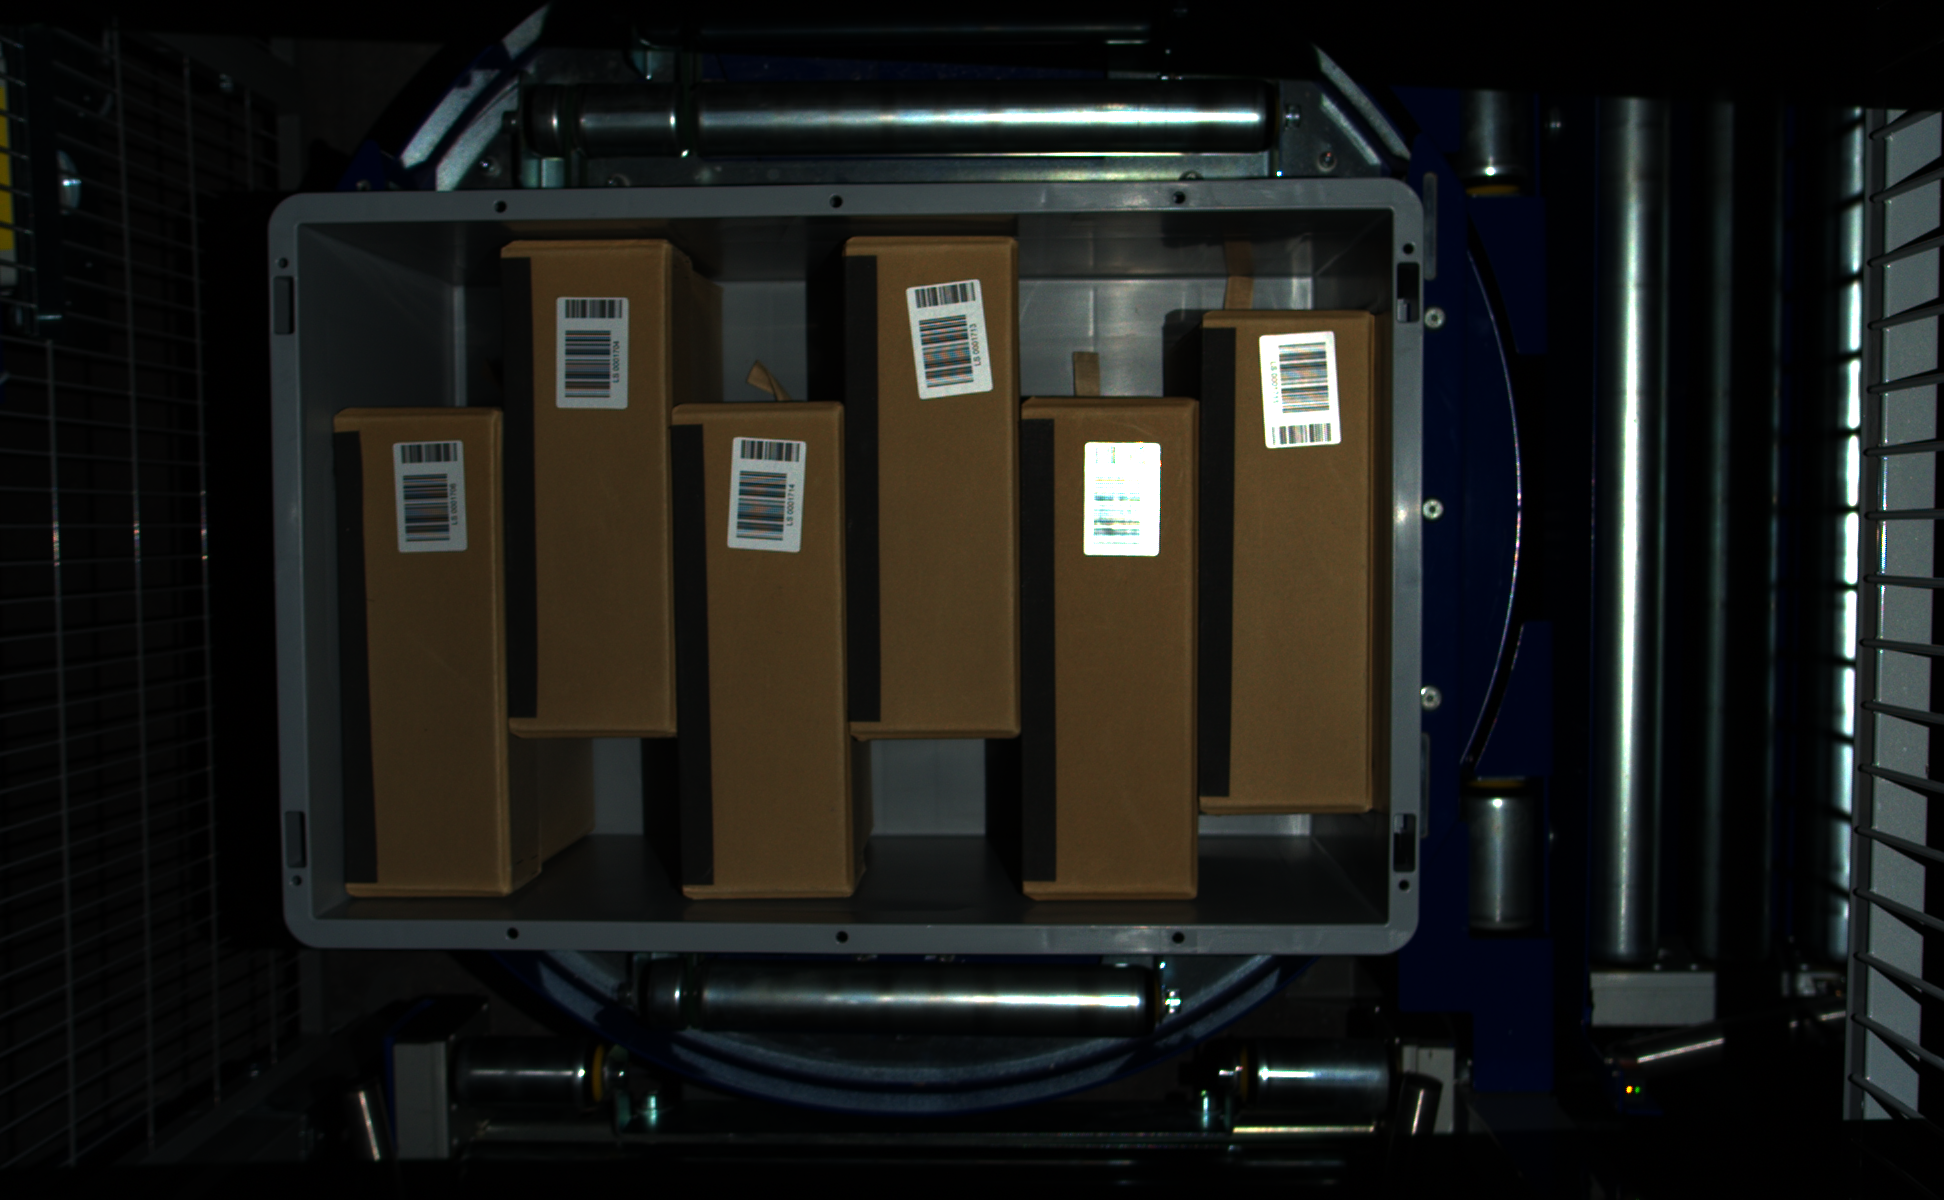

In [46]:
# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
print(image)
image = Image.open(os.path.join('../../../old/BAA/Data/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
print(annotations)
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}
print(id2label)

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=3)
  draw.text((x, y), id2label[class_idx], fill='red')

image

In [8]:
def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [9]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [10]:
pixel_values, target = train_dataset[0]

In [11]:
pixel_values.shape

torch.Size([3, 800, 1296])

In [12]:
print(target)

{'size': tensor([ 800, 1296]), 'image_id': tensor([20459]), 'class_labels': tensor([3, 3, 3, 3, 4, 9, 3, 4, 3]), 'boxes': tensor([[0.2143, 0.4163, 0.0207, 0.0484],
        [0.2136, 0.3283, 0.0101, 0.0287],
        [0.2470, 0.3345, 0.0287, 0.2091],
        [0.1827, 0.4289, 0.0229, 0.0400],
        [0.1771, 0.3152, 0.0128, 0.0143],
        [0.4923, 0.3270, 0.0201, 0.2061],
        [0.5701, 0.6044, 0.0130, 0.1321],
        [0.6888, 0.5454, 0.0080, 0.0661],
        [0.3953, 0.5449, 0.0367, 0.0385]]), 'area': tensor([ 791.8279,  260.5026, 5102.3174,  622.3292,  107.8912, 3677.6836,
         560.8431,  275.4464,  708.1031]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]), 'orig_size': tensor([1200, 1944])}


In [13]:
class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [14]:
# Start tensorboard.
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

# login to weights and biases, to relogin: wandb.login(key="YOUR KEY", relogin=True)
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: michael-infanger (damaged-books-detection-ml). Use `wandb login --relogin` to force relogin


True

In [15]:
date = datetime.datetime.now()
run_name = "Run at the {}".format(date)

lr = 1e-4
lr_backbone=1e-5
weight_decay=1e-4

project = "BAA_Book_Damage_Detection"

wandb.init(
    project=project,
    name=run_name,
    config={"learning_rate_transformer": lr,
            "learning_rate_backbone": lr_backbone,
            "weight_decay": weight_decay,
            "architecture": "DETR",
            "dataset": "minimal_set",
            "train_set_size": len(train_dataset)}
    )

model = Detr(lr=lr, lr_backbone=lr_backbone, weight_decay=weight_decay)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])
print(outputs.logits.shape)

wandb_logger = WandbLogger(project=project, log_model="all")
trainer = Trainer(max_steps=300, gradient_clip_val=0.1, logger=wandb_logger)
trainer.fit(model)
wandb.finish()

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([11, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([11]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([4, 100, 11])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\loggers\wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Michael\AppData\Local\Programs\Python

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.


## Evaluation

In [16]:
# pip install coco-eval


In [52]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [53]:
# pip install ipywidgets

In [54]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/3 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [55]:
#We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[1]
print(target)

{'size': tensor([ 800, 1296]), 'image_id': tensor([20547]), 'class_labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 9]), 'boxes': tensor([[0.2532, 0.4891, 0.0973, 0.0224],
        [0.2536, 0.5182, 0.0324, 0.0273],
        [0.2493, 0.5963, 0.1051, 0.0168],
        [0.1855, 0.6835, 0.0182, 0.0217],
        [0.3023, 0.2520, 0.0121, 0.0287],
        [0.3336, 0.4100, 0.0584, 0.0392],
        [0.4110, 0.4510, 0.0307, 0.0203],
        [0.5299, 0.2891, 0.0212, 0.0203],
        [0.4908, 0.3525, 0.1159, 0.0168],
        [0.5072, 0.3778, 0.0234, 0.0168],
        [0.4958, 0.4303, 0.0791, 0.0154],
        [0.4592, 0.5203, 0.0597, 0.0133],
        [0.4731, 0.4916, 0.0856, 0.0259],
        [0.6050, 0.4296, 0.0649, 0.0308],
        [0.5764, 0.5175, 0.0259, 0.0119],
        [0.5868, 0.5711, 0.0225, 0.0112],
        [0.6499, 0.5855, 0.0242, 0.0175],
        [0.6231, 0.6089, 0.0943, 0.0266]]), 'area': tensor([1674.1609,  707.1332, 1527.8033,  316.5846,  304.0217,  937.9761,
         58

In [56]:

pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 1296])


In [57]:

with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())
print(outputs)

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])
DetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-1.6537, -2.1510, -1.0882,  ..., -2.4253, -0.8894,  2.2040],
         [-2.1067, -2.2853, -0.6045,  ..., -2.4046, -0.1720,  2.6397],
         [-1.5925, -2.1513, -0.9230,  ..., -2.1737, -0.6174,  1.7450],
         ...,
         [-1.7577, -2.0559, -0.6986,  ..., -2.1573, -0.1346,  2.7347],
         [-0.8161, -1.6348, -1.0563,  ..., -1.8849, -0.3036,  4.6526],
         [-2.0657, -2.2975, -0.6331,  ..., -2.3395, -0.0791,  2.7094]]],
       device='cuda:0'), pred_boxes=tensor([[[0.2205, 0.5188, 0.0419, 0.0308],
         [0.5091, 0.3272, 0.0803, 0.0387],
         [0.2552, 0.6997, 0.0695, 0.0363],
         [0.5561, 0.2569, 0.0403, 0.0357],
         [0.4573, 0.2786, 0.0435, 0.0514],
         [0.4803, 0.5282, 0.0693, 0.0471],
         [0.4821, 0.4288, 0.0654, 0.0381],
         [0.3321, 0.5168, 0.0455, 0.0391],
         [0.3090, 0.27

In [74]:
pixel_values, target = val_dataset[4]
pixel_values = pixel_values.unsqueeze(0).to(device)

with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)

import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{id2label[label]}: {score:0.2f}'
        print(text)
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

Schmutz: 0.44
Schmutz: 0.59
Schmutz: 0.33
Schmutz: 0.41
Schmutz: 0.39
Schmutz: 0.48
Schmutz: 0.50
Schmutz: 0.47
Schmutz: 0.52
Schmutz: 0.35
Schmutz: 0.40
Schmutz: 0.30
Schmutz: 0.49
Schmutz: 0.54
Schmutz: 0.32
Schmutz: 0.49
Schmutz: 0.48
Schmutz: 0.31
Schmutz: 0.37
Schmutz: 0.32
Schmutz: 0.51
Schmutz: 0.38
Schmutz: 0.30
Schmutz: 0.32
Schmutz: 0.56
Schmutz: 0.33
Schmutz: 0.48
Schmutz: 0.47
Schmutz: 0.35
Schmutz: 0.45
Schmutz: 0.42
Schmutz: 0.54
Schmutz: 0.35
Schmutz: 0.41
Schmutz: 0.30
Schmutz: 0.52
Schmutz: 0.34
Schmutz: 0.47
Schmutz: 0.34
Schmutz: 0.35
Schmutz: 0.53
Schmutz: 0.35
Schmutz: 0.52
Schmutz: 0.50
Schmutz: 0.42
Schmutz: 0.46
Schmutz: 0.54
Schmutz: 0.39


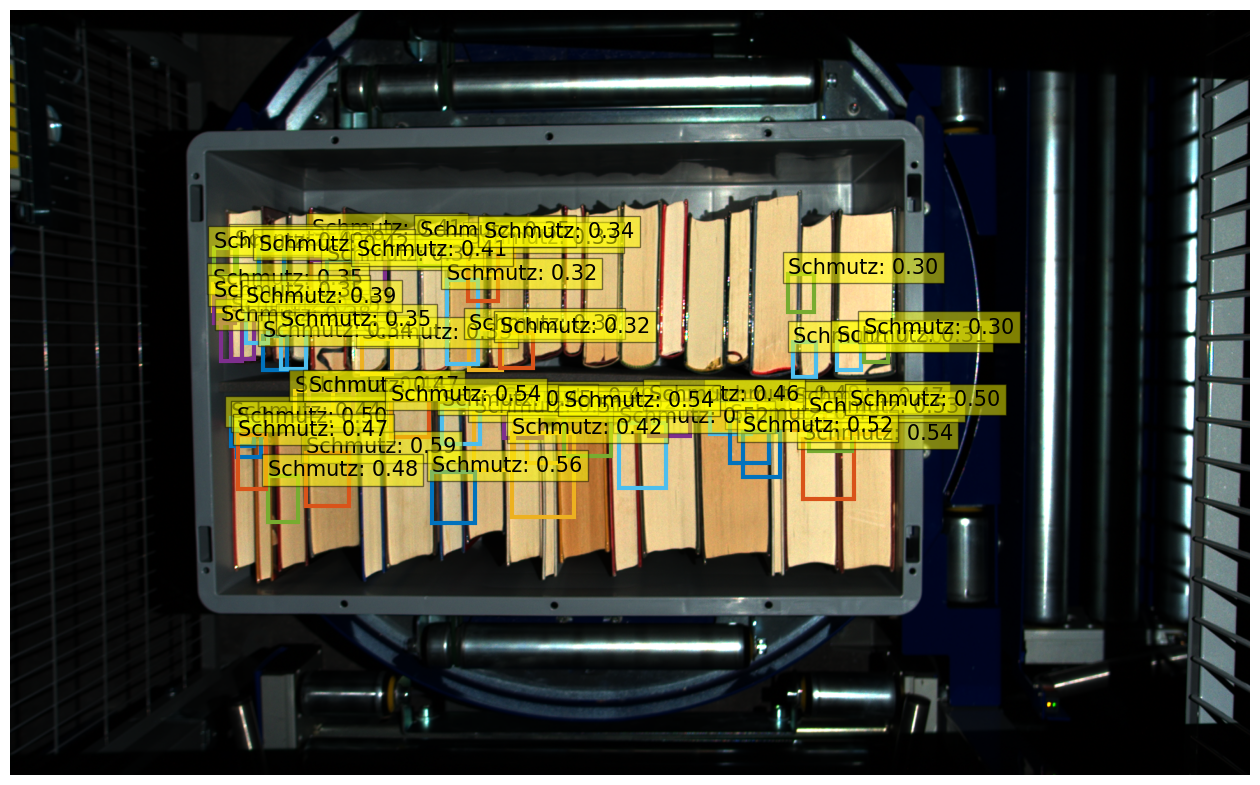

In [78]:
# load image based on ID
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('../../../old/BAA/Data/val', image['file_name']))

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.3)
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])